# scikit-learn for NLP -- Part 1 Introductory Tutorial

[scikit-learning](http://scikit-learn.org/stable/index.html) is an open-sourced simple and efficient tools for data mining, data analysis and machine learning in Python. It is built on [NumPy](https://numpy.org/), [SciPy](https://scipy.org/) and [matplotlib](https://matplotlib.org/). 

It expose interfaces for machine learning based classification, regression, and clustering models, as well as useful features like dimensionality reduction, evaluation and preprocessing.

It also implement a great set of features for Natural Language Processing (NLP), i.e. working with text data. Part one covers the following topics: loading data, simple preprocessing, training (supervised, semi-supervised, and unsupervised), and evaluation. Part two focuses on feature engineering and covers more advanced topics like feature extraction, building a pipeline, creating custom transformers, feature union, dimensionality reduction, etc. 

For this tutorial, we will use the [20 Newsgroups data set](http://qwone.com/~jason/20Newsgroups/) and perform topic classification.

### 1. Loading Dataset

We will use [pandas](https://pandas.pydata.org/) to read CSV file, just as a convention, considering that this library is the faster, and more flexible and easy to use open source data analysis and manipulation tool (to the best of my knowledge) built on top of the Python programming language.  

In [1]:
import pandas as pd

dataset = pd.read_csv('20news-18828.csv', header=None, delimiter=',', names=['label', 'text'])

Sanity check on the dataset.

In [2]:
print("There are 20 categories: %s" % (len(dataset.label.unique()) == 20))
print("There are 18828 records: %s" % (len(dataset) == 18828))

There are 20 categories: True
There are 18828 records: True


Now we need to split it to train set and test set. To do so, we can use the `train_test_split()` function. In scikit-learn's convention, X indicates data (yeah, uppercase X), and y indicates truths (and yeah, lowercase y). I mean, it doesn't really matter, as long as you remember what is what.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.text, dataset.label, train_size=0.8)

### 2. A Simple Example

Before going too much into preprocessing, feature extraction and other more complicated tasks, we will do a relatively simple but complete example. In this example, we will use bag-of-words as features, and Naive Bayes as classifier to establish our baseline.

There are some built-in vectorizers, `CountVectorizer` and `TfidfVectorizer` that we can use to vectorizer our raw data and perform preprocessing and feature exctration on it. First, we will experiment with `CountVectorizer` which basically makes a token/ngram a feature and stores its count in the corresponding feature space. The `fit_transform()` function is the combination of `fit()` and `transform()`, and it's a more efficient implementation. `fit()` indexes the vocabulary/features, and `transform()` transforms the dataset into a matrix. 

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
# initialize a CountVectorizer
cv = CountVectorizer()
# fit the raw data into the vectorizer and tranform it into a series of arrays
X_train_counts = cv.fit_transform(X_train)
X_train_counts.shape

(15062, 183326)

Similar thing needs to be done for the test set, but we only need to use the `transform()` function to transform the test data into a matrix. 

In [5]:
X_test_counts = cv.transform(X_test)
X_test_counts.shape

(3766, 183326)

Then, we fit our features and labels into a Naive Bayes classifier, which basically trains a model (if you fit the data more than once, it overwrites the parameters the model learns previously). After training, we can use it to perform prediction.

In [6]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_counts, y_train)
predicted = clf.predict(X_test_counts)

# sample some of the predictions against the ground truths 
for prediction, truth in zip(predicted[:10], y_test[:10]):
    print(prediction, truth)

rec.autos rec.autos
talk.religion.misc talk.religion.misc
sci.crypt sci.crypt
talk.politics.guns talk.politics.guns
rec.sport.baseball rec.sport.baseball
alt.atheism alt.atheism
comp.sys.mac.hardware comp.sys.mac.hardware
alt.atheism talk.religion.misc
comp.windows.x comp.windows.x
rec.motorcycles rec.motorcycles


Let's do some legit evaluation. The `classification_report()` function gives you precison, recall and f1 scores for each label, and their average. If you want to calculate overall macro-averaged, micro-averaged or weighted performance, you can use the `precision_recall_fscore_support`. Finally, the `confusion_matrix()` can show you which labels are confusing to the model, but unfortunately, it does not include the labels. I think that's why they call it a confusion matrix.

In [26]:
from sklearn import metrics

print(metrics.classification_report(y_test, predicted, labels=dataset.label.unique()))

p, r, f1, _ = metrics.precision_recall_fscore_support(y_test, predicted, labels=dataset.label.unique(), average='micro')

print("Micro-averaged Performance:\nPrecision: {0}, Recall: {1}, F1: {2}".format(p, r, f1))

                          precision    recall  f1-score   support

             alt.atheism       0.92      0.92      0.92       169
           comp.graphics       0.65      0.86      0.74       194
 comp.os.ms-windows.misc       0.89      0.12      0.21       204
comp.sys.ibm.pc.hardware       0.66      0.85      0.74       195
   comp.sys.mac.hardware       0.89      0.88      0.89       182
          comp.windows.x       0.74      0.90      0.81       210
            misc.forsale       0.91      0.70      0.79       183
               rec.autos       0.91      0.89      0.90       187
         rec.motorcycles       0.97      0.92      0.95       197
      rec.sport.baseball       0.99      0.93      0.96       220
        rec.sport.hockey       0.97      0.99      0.98       197
               sci.crypt       0.79      0.94      0.86       179
         sci.electronics       0.88      0.73      0.80       204
                 sci.med       0.96      0.92      0.94       198
         

## Plot Confusion Matrix

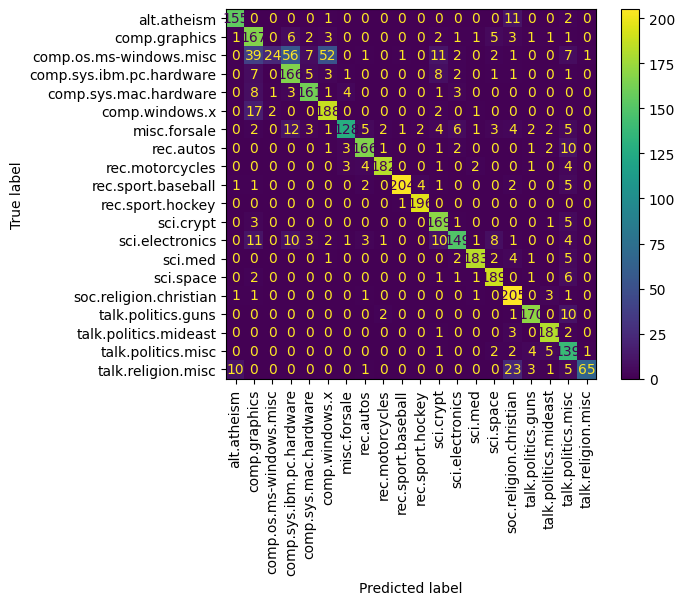

In [25]:
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test, predicted, labels=dataset.label.unique())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.xticks(rotation=90)
plt.show()

### 3. Preprocessing & Feature Extraction

One may ask, "how do I remove stop words, tokenize the texts differently, or use bigrams/trigrams as features?" 
The answer is you can do all that with a [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object, i.e. you can pass various arguments to the constructor. 

Here are some of them: `ngram_range` takes in a tuple (n_min, n_max). For example, `(2,2)` means only use bigrams, and `(1,3)` means use unigrams, bigrams, and trigrams. `stop_words` takes in a list of stopwords that you'd like to remove. If you want to use default stopword list in scikit-learn, pass in the string `'english'`. `tokenizer` is a function that takes in a string and returns a string, inside that function, you can define how to tokenize your text. By default, scikit-learn tokenization pattern is `u'(?u)\b\w\w+\b'`. Finally, `preprocessor` takes in a function of which the argument is a string and the output is a string. You can use it to perform more customized preprocessing. For more detail, please checkout the documentation for `CountVectorizer` or `TfidfVectorizer`.

Let's start with defining a preprocessor to normalize all the numeric values, i.e. replacing numbers with the string `NUM`. Then, we construct a new `CountVectorizer`, and then use unigrams, bigrams, and trigrams as features, and remove stop words.  

In [8]:
import re
def normalize_numbers(s):
    return re.sub(r'\b\d+\b', 'NUM', s)

cv = CountVectorizer(preprocessor=normalize_numbers, ngram_range=(1,3), stop_words='english')

Let's fit and transform the train data and transform the test data. The speed of preprocessing and feature extraction depends on the running time of each step. For example, the running time of stopword removal is O(N * M), where N is the vocabulary size of the document, and M is the stopword list size.

In [9]:
# fit the raw data into the vectorizer and tranform it into a series of arrays
X_train_counts = cv.fit_transform(X_train)
X_test_counts = cv.transform(X_test)

Let's use the Naive Bayes classifier to train a new model and see if it works better. From the last section with out preprocessing or feature engineering, our precison, recall and F1 are in the mid 80s, but now we got 90 for each score.

In [10]:
clf = MultinomialNB().fit(X_train_counts, y_train)
predicted = clf.predict(X_test_counts)
print(metrics.classification_report(y_test, predicted, labels=dataset.label.unique()))

                          precision    recall  f1-score   support

             alt.atheism       0.96      0.96      0.96       161
           comp.graphics       0.71      0.85      0.77       178
 comp.os.ms-windows.misc       0.89      0.82      0.86       203
comp.sys.ibm.pc.hardware       0.78      0.79      0.78       191
   comp.sys.mac.hardware       0.94      0.81      0.87       207
          comp.windows.x       0.83      0.89      0.86       197
            misc.forsale       0.90      0.78      0.83       198
               rec.autos       0.93      0.93      0.93       213
         rec.motorcycles       1.00      0.96      0.98       220
      rec.sport.baseball       0.95      0.94      0.94       183
        rec.sport.hockey       0.88      0.98      0.93       198
               sci.crypt       0.88      0.99      0.93       182
         sci.electronics       0.92      0.84      0.88       215
                 sci.med       0.97      0.95      0.96       197
         

Do you remember there are other vecotrizers that you can use? Walla, one of them is `TfidfVecotrizer`. LOL, what is tf-idf? It's on [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). It basically reflects how important a word/phrase is to a document in a corpus. The constructor of `TfidfVectorizer` takes in the same parameters as that of `CountVectorizer`, so you can perfrom the same preprocessing/feature extraction. Try to run the following block of code and see if using tf-idf will help improve the performance. There are some other parameters in the constructor that you can tweak when initializing the object, and they could affect the performance as well.   

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(preprocessor=normalize_numbers, ngram_range=(1,3), stop_words='english')
X_train_tf = tv.fit_transform(X_train)
X_test_tf = tv.transform(X_test)
clf2 = MultinomialNB().fit(X_train_tf, y_train)
predicted = clf2.predict(X_test_tf)
print(metrics.classification_report(y_test, predicted, labels=dataset.label.unique()))

                          precision    recall  f1-score   support

             alt.atheism       0.94      0.93      0.93       161
           comp.graphics       0.79      0.82      0.81       178
 comp.os.ms-windows.misc       0.82      0.90      0.86       203
comp.sys.ibm.pc.hardware       0.74      0.84      0.79       191
   comp.sys.mac.hardware       0.96      0.83      0.89       207
          comp.windows.x       0.93      0.84      0.88       197
            misc.forsale       0.90      0.83      0.87       198
               rec.autos       0.92      0.92      0.92       213
         rec.motorcycles       0.96      0.98      0.97       220
      rec.sport.baseball       0.92      0.97      0.94       183
        rec.sport.hockey       0.95      0.98      0.96       198
               sci.crypt       0.88      0.99      0.94       182
         sci.electronics       0.94      0.83      0.88       215
                 sci.med       0.99      0.95      0.97       197
         

Alternatively, if you like typing a longer block of code, you can use the `TfidfTransformer` to transform a word count matrix created by `CountVectorizer` into a tf-idf matrix.

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

### 4. Model Selection

Depending on the size of your data and the nature your task, some classifiers might perform better than others. These days, Maximum Entropy is a very popular classifier for many machine learning tasks, and every often, it is used to establish the baseline for a task. So let's try the [logistic regression classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) in scikit-learn (Maxent and logistic regression are virtually the same thing). Please note that this classifier is a lot slower than Naive Bayes, because of [math and whatever](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) (JK, Maxent updates the weights for each feature for some iterations, whereas Naive Bayes only calculates the probabilities of each feature at once). 

In [13]:
from sklearn.linear_model import LogisticRegression

# for the sake of speed, we will just use all the default value of the constructor
cv = CountVectorizer()
X_train_counts = cv.fit_transform(X_train)
X_test_counts = cv.transform(X_test)

clf = LogisticRegression(solver='liblinear', max_iter=500, n_jobs=4)
clf.fit(X_train_counts, y_train)
predicted = clf.predict(X_test_counts)
print(metrics.classification_report(y_test, predicted, labels=dataset.label.unique()))

C:\Users\Chiqu\Documents\GitHub\NLP_Hands_On_UNIMC\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


                          precision    recall  f1-score   support

             alt.atheism       0.93      0.89      0.91       161
           comp.graphics       0.77      0.83      0.80       178
 comp.os.ms-windows.misc       0.82      0.88      0.85       203
comp.sys.ibm.pc.hardware       0.78      0.76      0.77       191
   comp.sys.mac.hardware       0.92      0.89      0.90       207
          comp.windows.x       0.90      0.86      0.88       197
            misc.forsale       0.84      0.87      0.85       198
               rec.autos       0.89      0.92      0.91       213
         rec.motorcycles       0.98      0.94      0.96       220
      rec.sport.baseball       0.94      0.94      0.94       183
        rec.sport.hockey       0.97      0.97      0.97       198
               sci.crypt       0.97      0.94      0.96       182
         sci.electronics       0.85      0.84      0.85       215
                 sci.med       0.93      0.97      0.95       197
         

There are many other supervised, semi-supervised and unsupervised algorithms, and many of them work almost the same: (1) initialize a classifier, (2) fit the feature matrix and labels of the train set, and (3) pass in the feature matrix of test set to perform prediction. 

The following is an example of semi-supervised algorithm, label spreading, which uses both labeled and unlabeled data to train a classifier. It is especially nice when you don't have too much annotated data.

In [14]:
from sklearn.semi_supervised import LabelSpreading
from sklearn import preprocessing
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

label_prop_model = LabelSpreading()
# randomly select some of the training data and use them as unlabeled data
random_unlabeled_points = np.where(np.random.randint(0, 2, size=len(y_train)))
labels = np.copy(y_train)
# convert all labels into indecies, since we'll assign -1 to the unlabeled dataset
le = preprocessing.LabelEncoder()
le.fit(labels)
# transforms labels to numeric values
labels = le.transform(labels)
labels[random_unlabeled_points] = -1
labels_test = le.transform(y_test)

# here we will need to limit the features space, because we are going to convert the sparse
# matrices into dense ones required by the implementation of LabelSpreading. 
# Using dense matrices in general slows down training and takes up a lot of memory; therefore,
# in most cases, it is not recommended.
cv = CountVectorizer(max_features=100)
X_train_counts = cv.fit_transform(X_train)
X_test_counts = cv.transform(X_test)
# toarray() here is to convert a sparse matrix into a dense matrix, as the latter is required
# by the algorithm. 
label_prop_model.fit(X_train_counts.toarray(), labels)
predicted = label_prop_model.predict(X_test_counts.toarray())

# For this experiment, we are only using 100 most frequent words as features in the train set, 
# so the test results will be lousy. 
p, r, f1, _ = metrics.precision_recall_fscore_support(labels_test, predicted, average='macro')
print("Macro-averaged Performance:\nPrecision: {0}, Recall: {1}, F1: {2}".format(p, r, f1))

Macro-averaged Performance:
Precision: 0.26045847064432354, Recall: 0.13100125347735264, F1: 0.1242376626643312


C:\Users\Chiqu\Documents\GitHub\NLP_Hands_On_UNIMC\venv\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


## Clustering 

Clustering algorithms, which amount to a class of unsupervised ML models have great value in NLP, particularly for tasks like news segmentation, where it was adopted to efficiently organize large volumes of news articles into coherent and meaningful clusters, enabling streamlined analysis and retrieval of relevant information.

<!-- In general, NLP Clustering involves grouping similar data points based on their features or characteristics identifying patterns and similarities among textual data, facilitating tasks such as document organization, topic modeling, and sentiment analysis.  -->

### KMeans Algorithm

KMeans is a popular clustering algorithm widely used in NLP for its simplicity and efficiency. It iteratively partitions the data into a predefined number of clusters, with each cluster represented by its centroid. By iteratively optimizing the cluster centroids to minimize the within-cluster sum of squares, KMeans efficiently groups similar documents together while maximizing the differences between clusters.

In news segmentation, KMeans clustering organizes vast amounts of news articles into cohesive groups based on shared topics, events, or themes. 

This segmentation enables efficient content recommendation, targeted advertising, and trend analysis. Moreover, by automatically clustering news articles, NLP systems can adapt to dynamic news environments, ensuring timely and relevant content delivery to users.

![SegmentLocal](K-means_convergence.gif "segment")

### Perform KMeans with sklearn

In [15]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(dataset.text, dataset.label, train_size=0.8)
# I reduced the number of features here just to make training a little faster
cv = CountVectorizer(max_features=200)
X_train_counts = cv.fit_transform(X_train)
X_test_counts = cv.transform(X_test)

kmeans = KMeans(n_clusters=20, random_state=0)
kmeans.fit(X_train_counts)
# see the cluster label for each instance
print(kmeans.labels_)
print(kmeans.predict(X_test_counts))

le = preprocessing.LabelEncoder()
le.fit(y_train)
# you can also pass in the labels, if you have some annotated data
kmeans.fit(X_train_counts, le.transform(y_train))
predicted = kmeans.predict(X_test_counts)
p, r, f1, _ = metrics.precision_recall_fscore_support(le.transform(y_test), predicted, average='macro')
print("Macro-averaged Performance:\nPrecision: {0}, Recall: {1}, F1: {2}".format(p, r, f1))

[ 0  5 13 ... 13 13 13]
[13 18 13 ... 13 18 13]
Macro-averaged Performance:
Precision: 0.013080982742459054, Recall: 0.05040171911658163, F1: 0.014300477220620177


C:\Users\Chiqu\Documents\GitHub\NLP_Hands_On_UNIMC\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 6. Conclusion
In this tutorial, we went through some basic features of scikit-learn that allow us to perform a basic ML NLP classification task, obtaining interesting results on a toy dataset.

As self-study, you could investigate how transfomers have revolutionized NLP classification ([Interesting research paper](https://ieeexplore.ieee.org/document/10380590)). 